YF.download() has changed argument auto_adjust default to True
VaR histórico (95%): -3.55%
CVaR histórico (95%): 5.24%
CVaR (programación lineal, 95%): 5.25%


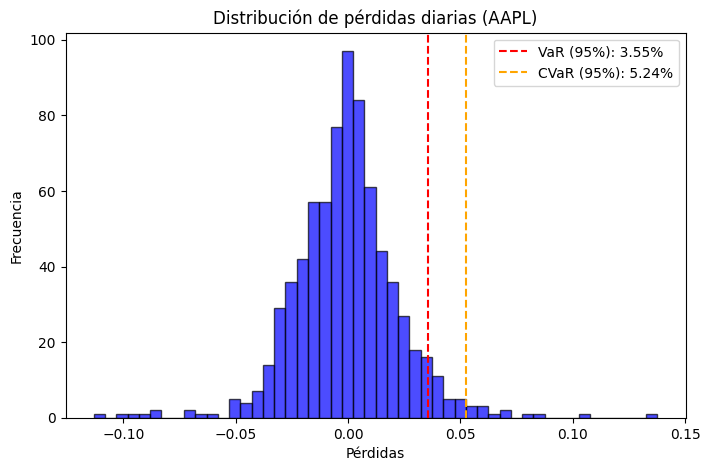

In [1]:
# Ejemplo: Cálculo de VaR y CVaR para Apple (AAPL) y formulación de CVaR como programación lineal

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# 1. Descargar datos históricos de Apple
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01', progress=False)
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# 2. Calcular el VaR histórico al 95%
confidence_level = 0.95
VaR = np.percentile(data['Returns'], (1 - confidence_level) * 100)
print(f"VaR histórico (95%): {VaR:.2%}")

# 3. Calcular el CVaR histórico al 95%
losses = -data['Returns']  # Pérdidas (negativo de los retornos)
VaR_threshold = np.percentile(losses, confidence_level * 100)
CVaR = losses[losses >= VaR_threshold].mean()
print(f"CVaR histórico (95%): {CVaR:.2%}")

# 4. Formulación de CVaR como problema de programación lineal
# Usamos los retornos negativos (pérdidas) como escenarios
N = len(losses)
alpha = confidence_level

# Variables de decisión
zeta = cp.Variable()  # Umbral VaR
u = cp.Variable(N)    # Exceso de pérdida sobre VaR

# Restricciones
constraints = [
    u >= losses.values - zeta,
    u >= 0
]

# Función objetivo (minimizar CVaR)
objective = cp.Minimize(zeta + (1 / ((1 - alpha) * N)) * cp.sum(u))

# Problema de optimización
problem = cp.Problem(objective, constraints)
problem.solve()

print(f"CVaR (programación lineal, 95%): {problem.value:.2%}")

# 5. Visualización
plt.figure(figsize=(8,5))
plt.hist(losses, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(VaR_threshold, color='red', linestyle='--', label=f'VaR (95%): {VaR_threshold:.2%}')
plt.axvline(CVaR, color='orange', linestyle='--', label=f'CVaR (95%): {CVaR:.2%}')
plt.title('Distribución de pérdidas diarias (AAPL)')
plt.xlabel('Pérdidas')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()